# CS4240 Deep Learning - Assignment 2

*These lab assignments are new in the CS4240 Deep Learning course. We'd like to hear what you think!*

*Please post any feedback you have on Brightspace. Thanks!*

To start working on the assignment in Colab, save a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`).

To work on the assignments locally, configure your conda environment (see instructions on Brightspace) and download this assignment as an IPython Notebook (`File` $\rightarrow$ `Download .ipynb`).

## Introduction

In this assignment you will be introduced to the backpropagation algorithm and you will train your first neural network. We will continue from the layers implemented in the previous assignment and define the backward passes to compute gradients. Finally, you will use your neural network to solve the XOR problem from the previous assignment, as well as to classify handwritten digits from the MNIST dataset.

**Prerequisites:**
* Completion of previous assignment.
* Basic knowledge of Python and Numpy. Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).
* We recommend you to have a look at [this excellent tutorial on PyTorch Tensors](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

**Learning objectives:**
* Understanding, deriving and implementing the backward pass for a fully connected layer and the ReLU and Sigmoid non-linear activation functions in PyTorch;
* Understanding and implementing the backpropagation algorithm and the training loop;
* Understanding Softmax and the cross-entropy loss.

We will share the solutions one week after the assignments are published. Throughout the assignment you will validate your code by comparing the outputs of your own implementations to the equivalent PyTorch implementations.

**For your own implementations you may only use basic tensor operations from the `torch` module: no `torch.nn`, `torch.nn.F` or others.**

---

When answering coding questions make sure to write your own code within the designated part of the code block as illustrated here:
```python
#############################################################################
#                       TODO: Implement function x                          #
#############################################################################
# Replace "pass" statement with your code
pass
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Please pay attention to the question boxes and try to think about them. The boxes are indicated as follows:

****
**Questions?**
****

In [2]:
# Setup
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/home/fgheri/miniconda3/envs/deep_learning/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## A2.1 Linear layer - backward pass

In A2.1 we will build upon the linear layer from A1.1 and implement the backward pass. We then perform a forward pass and backward pass on some dummy input and compare the gradients to the Pytorch implementation of a Linear layer.

**Backpropagation**

Backpropagation is an efficient algorithm to modularly calculate the gradients of the loss $\mathcal{L}$ with respect to the trainable parameters in our network. The gradient is used in (Stochastic) Gradient Descent to update the trainable parameters to minimize the loss. For now we only consider how to calculate the gradients in the `backward` function of a layer, later on we will also implement the update step.

The forward pass of a linear layer is defined as $y=xw+b$, where $w$ and $b$ are the trainable weight and bias parameters, respectively. The gradients w.r.t. $w$ and $b$ are then calculated using the chain rule as
$$\frac{\partial \mathcal{L}}{\partial w} = \frac{\partial \mathcal{L}}{\partial y} \frac{\partial y}{\partial w}, \qquad \frac{\partial \mathcal{L}}{\partial b} = \frac{\partial \mathcal{L}}{\partial y} \frac{\partial y}{\partial b}.$$

Here, $\frac{\partial \mathcal{L}}{\partial y}$ is the *upstream gradient*, i.e. the gradient flowing from the deeper layer into the current layer. The upstream gradient will be the input variable in our `backward` function.
The other two terms are the *local gradients* and will be computed inside the `backward` function as
$$\frac{\partial y}{\partial w}=x, \qquad \frac{\partial y}{\partial b}=1.$$

As you can see, the input of the layer $x$ is used for computing the gradient in the backward pass. We therefore need to store this value during the forward pass as a cache variable so that we don't have to compute it again.

Furthermore, since the shallower layer also requires an upstream gradient, our `backward` future needs to return a *downstream gradient*. The downstream gradient of a layer is simply its upstream gradient times the local gradient of its ouput with respect to its input: $\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial y} \frac{\partial y}{\partial x}$. For a linear layer $\frac{\partial y}{\partial x}=w$ and so $\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial y} w$.

Let us further clarify using an example with a two-layer neural network. The network output is given by
$$y_2 = y_1 w_2 + b_2 = (x_1 w_1 + b_1) w_2 + b_2.$$
The gradients for the first layer are calculated using the chain rule:
$$ \frac{\partial \mathcal{L}}{\partial w_1} = \frac{\partial \mathcal{L}}{\partial y_2} \frac{\partial y_2}{\partial y_1} \frac{\partial y_1}{\partial w_1} = \frac{\partial \mathcal{L}}{\partial y_1} \frac{\partial y_1}{\partial w_1}.$$

From the perspective of layer 2, $\frac{\partial \mathcal{L}}{\partial y_2}$ is the upstream gradient, $\frac{\partial y_2}{\partial y_1} = \frac{\partial y_2}{\partial x_2} = w_2$ is the local gradient, and $\frac{\partial \mathcal{L}}{\partial y_2} \frac{\partial y_2}{\partial y_1} = \frac{\partial \mathcal{L}}{\partial y_1}$ is the downstream gradient. From the perspective of layer 1, $\frac{\partial \mathcal{L}}{\partial y_1}$ is the upstream gradient.

You will now implement the `backward` function in the code block below.

In [3]:
 class Linear(object):
    """
    Fully connected layer.

    Args:
        in_features: number of input features
        out_features: number of output features
    """

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        # Define placeholder tensors for layer weight and bias. The placeholder
        # tensors should have the correct dimension according to the in_features
        # and out_features variables.
        self.weight = torch.Tensor(in_features, out_features)
        self.bias = torch.Tensor(out_features)

        # Initialize parameters
        self.init_params()

        # NEW: Define a cache varible to save computation, because some of the
        # forward pass values would be used during backward pass.
        self.cache = None

        # NEW: Define variables to store the gradients of the weight and bias
        # calculated during the backward pass
        self.weight_grad = None
        self.bias_grad = None

    def init_params(self, std=1.):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias uniform distribution.

        Args:
            std: Standard deviation of Gaussian distribution (default: 1.0)
        """

        self.weight = std*torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x):
        """
        Forward pass of linear layer: multiply input tensor by weights and add
        bias. Store input tensor as cache variable.

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        y = torch.mm(x, self.weight) + self.bias  # forward pass

        ########################################################################
        #                TODO: Store input as cache variable                   #
        ########################################################################

        self.cache = x

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

    def backward(self, dupstream):
        """
        Backward pass of linear layer: calculate gradients of loss with respect
        to weight and bias and return downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """
        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        x = self.cache
        dx = torch.mm(dupstream, self.weight.T)
        self.weight_grad = torch.mm(x.T, dupstream)
        self.bias_grad = torch.sum(dupstream, dim=0)

        # dx = torch.mm(dLdw, self.weight)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ##############w##########################################################

        return dx

Now test the forward and backward pass of the layer on some dummy input.

****
**What will be the shape of gradient of x w.r.t. y?**
****

In [4]:
# Define layer dimensions
n_samples, in_features, out_features = 2, 3, 4
# Make random input tensor of dimensions [n_samples, in_features]
x = torch.randn((n_samples, in_features))
# Define upstream gradient dL/dy as randn
dy = torch.randn((n_samples, out_features))

# Create a layer from the Linear object class above
layer = Linear(in_features, out_features)
# Forward pass
y = layer.forward(x)
# Backward pass
dx = layer.backward(dy)

# What will be the shape of gradient of x w.r.t. y?
print('Shape of gradient x is:', dx.shape)
print('Shape correct: ', dx.shape == x.shape)

Shape of gradient x is: torch.Size([2, 3])
Shape correct:  True


If the above code block has not returned any errors we can compare our implementation to the PyTorch linear layer [[docs](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)] from `torch.nn`. We do so by initializing a `nn.Linear` layer and setting the `weight` and `bias` to the same values as in our own linear layer.

PyTorch layers store their parameters as a `Parameter`, which is a `Tensor` subclass with some special properties [[docs](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)]. We therefore need to wrap our `layer.weight` and `layer.bias` in a `nn.Parameter` when using in `nn.Linear`. Moreover, the `weight` tensor is transposed in `nn.Linear`.

PyTorch does not require the gradients to be specified for each layer individually but instead uses a mechanism called Autograd for automatic differentiation. To enable this for our dummy input we need to set the `requires_grad` parameter of the input tensor to `True`. More information about Autograd can be found in the official [docs](https://pytorch.org/docs/stable/notes/autograd.html) and in this excellent [tutorial](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/).

In [5]:
# Create Linear layer from torch.nn module
torch_layer = nn.Linear(in_features, out_features)

# Load the parameters from our layer into the Pytorch layer
torch_layer.weight = nn.Parameter(layer.weight.T) # transpose weight by .t()
torch_layer.bias = nn.Parameter(layer.bias)

# We create a copy of the input tensor so we can use x for all other layers
# without overwriting its gradients
x_lin = x.clone()
# Enable requires_grad for x_lin
x_lin.requires_grad = True

# Perform forward pass
torch_y = torch_layer(x_lin)

# Perform bacward pass
torch_y.backward(dy)

# What will be the shape of gradient of x w.r.t. y?
print('Shape of gradient x is:', dx.shape)
print('Shape correct:', x_lin.grad.shape == x_lin.shape)

Shape of gradient x is: torch.Size([2, 3])
Shape correct: True


We now compare the gradients of both implementations using `torch.allclose` [[docs](https://pytorch.org/docs/stable/generated/torch.allclose.html)], which returns `True` if all elements in both tensors are sufficiently "close" to each other.

Your backward implementation of the linear layer is therefore correct if `True` is returned for all gradients.

In [6]:
# Compare gradients of x, weight, bias w.r.t. y using torch.allclose
dx_same = torch.allclose(dx, x_lin.grad)
print('dx identical: ', dx_same)
dw_same = torch.allclose(layer.weight_grad, torch_layer.weight.grad.T)
print('dw identical: ', dw_same)
db_same = torch.allclose(layer.bias_grad, torch_layer.bias.grad)
print('db identical: ', db_same)

dx identical:  True
dw identical:  True
db identical:  True


## A2.2 Non-linear activation functions - backward pass

Similarly we implement the backward passes for both non-linearities. The non-linearities are defined as follows:

$$\text{ReLU}(x)=\max(0,x)\\
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1+\exp(-x)}$$

The derivations of the derivatives are left for you as an exercise.

In [21]:
class ReLU(object):
    """
    ReLU non-linear activation function.
    """

    def __init__(self):
        super(ReLU, self).__init__()

        # NEW: Define a cache variable because some of the forward pass values
        # would be used during backward pass.
        self.cache = None

    def forward(self, x):
        """
        Forward pass of ReLU non-linear activation function: y=max(0,x). Store
        input tensor as cache variable.

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        y = torch.clamp(x, min=0)  # forward pass

        ########################################################################
        #                   TODO: Update cache variable.                       #
        ########################################################################

        self.cache = x

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

    def backward(self, dupstream):
        """
        Backward pass of ReLU non-linear activation function: return downstream
        gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # Making sure that we don't modify the incoming upstream gradient
        dupstream = dupstream.clone()

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################


        y = self.cache 
        dx = dupstream 
        dx[y == 0] = 0 
        # if dupstream == 0:
        #     dx = 0
        # else : 
        #     dx = dupstream

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return dx

class Sigmoid(object):
    """
    Sigmoid non-linear activation function.
    """

    def __init__(self):
        super(Sigmoid, self).__init__()

        # NEW: Define a cache variable because some of the forward pass value
        # would be used during backward pass.
        self.cache = None

    def forward(self, x):
        """
        Forward pass of Sigmoid non-linear activation function: y=1/(1+exp(-x)).
        Store input tensor as cache variable.

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        y = 1.0 / (1.0 + torch.exp(-x))

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        self.cache = x

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

    def backward(self, dupstream):
        """
        Backward pass of Sigmoid non-linear activation function: return
        downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        y = self.cache
        # dx = y * (1 - y) * dupstream
        y = self.cache
        dx = (dupstream * y)/ ((1+y)**2)
        # dx = torch.mm(dupstream, (torch.exp**(-x)) / (1+ e**(-x))**(2))

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return dx

Test the backward pass of both non-linearities using the dummy input and gradients from before.

****
**What will be the shapes of the output tensors?**
****

In [22]:
# Define layer dimensions and dummy input
n_samples, in_features = 2, 3
# Make random input tensor of dimensions [n_samples, in_features]
x = torch.randn((n_samples, in_features))

# Define ReLU and Sigmoid layers
relu = ReLU()
sigmoid = Sigmoid()

# Define upstream gradient dL/dy as ones
dy = torch.randn((n_samples, in_features))
print('dy:', dy)

########################################################################
#    TODO: Perform a forward and backward pass with the ReLU and       #
#                          Sigmoid functions                           #
########################################################################

y_relu = relu.forward(x)
dx_relu = relu.backward(dy)

y_sigmoid = sigmoid.forward(x)
dx_sigmoid = sigmoid.backward(dy)

########################################################################
#                         END OF YOUR CODE                             #
########################################################################

# What will be the shapes of gradient tensors dx_relu and dx_sigmoid?
print('Output shapes from ReLU and Sigmoid: ', dx_relu.shape, dx_sigmoid.shape)
print('Shape of gradient x from ReLU correct:', dx_relu.shape == x.shape)
print('Shape of gradient x from Sigmoid correct:', dx_sigmoid.shape == x.shape)

dy: tensor([[ 1.9651,  0.0146,  0.0321],
        [ 0.8477,  0.7607, -1.5788]])
Output shapes from ReLU and Sigmoid:  torch.Size([2, 3]) torch.Size([2, 3])
Shape of gradient x from ReLU correct: True
Shape of gradient x from Sigmoid correct: True


Now perform a forward and backward pass with the ReLU and Sigmoid activation functions from `torch.nn` and compare the outputs to your implementation.

A list of all available non-linearities in PyTorch can be found [[here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)].

In [23]:
# We create a copy of the input tensor so we can use x for all other layers
# without overwriting its gradients
x_relu = x.clone()
x_sigmoid = x.clone()
# Enable requires_grad
x_relu.requires_grad = True
x_sigmoid.requires_grad = True

print('dy: ', dy)
print('---')

# ReLU forward pass
torch_relu = nn.ReLU()
torch_y_relu = torch_relu(x_relu)
torch_y_relu.backward(dy)

# Sigmoid forward pass
torch_sigmoid = nn.Sigmoid()
torch_y_sigmoid = torch_sigmoid(x_sigmoid)
torch_y_sigmoid.backward(dy)

# Compare outputs using torch.allclose
dx_relu_same = torch.allclose(dx_relu, x_relu.grad)
print('dx_relu identical: ', dx_relu_same)

print(f"dx_relu:\n {dx_relu}")
print(f"pytorch x_relu.grad:\n {x_relu.grad}")

print('---')

dx_sigmoid_same = torch.allclose(dx_sigmoid, x_sigmoid.grad)
print('dx_sigmoid identical: ', dx_sigmoid_same)

print(f"dx_sigmoid:\n {dx_sigmoid}")
print(f"pytorch x_sigmoid.grad:\n {x_sigmoid.grad}")

dy:  tensor([[ 1.9651,  0.0146,  0.0321],
        [ 0.8477,  0.7607, -1.5788]])
---
dx_relu identical:  False
dx_relu:
 tensor([[ 1.9651,  0.0146,  0.0321],
        [ 0.8477,  0.7607, -1.5788]])
pytorch x_relu.grad:
 tensor([[ 0.0000,  0.0146,  0.0321],
        [ 0.8477,  0.7607, -1.5788]])
---
dx_sigmoid identical:  False
dx_sigmoid:
 tensor([[-2.2820e+01,  3.3359e-03,  7.9638e-03],
        [ 2.1015e-01,  1.8039e-01, -3.7752e-01]])
pytorch x_sigmoid.grad:
 tensor([[ 0.4287,  0.0017,  0.0068],
        [ 0.1791,  0.1725, -0.2314]])


## A2.3 Network class - backward pass and update step

We will now extend our neural network class with a `backward` function that calculates the gradients for all parameters in the network and a `optimizer_step` function that performs a parameter update step using gradient descent. After calculating the gradients the weights and biases are updated as
$$w' = w - \eta\frac{\partial L}{\partial w}, \qquad b' = b - \eta\frac{\partial L}{\partial b},$$
where $w'$ and $b'$ are the new weights and biases and $\eta$ is the gradient descent step size, also called the learning rate.

In [46]:
class Net(object):
    """
    Neural network object containing layers.

    Args:
        layers: list of layers in neural network
    """
    def __init__(self, layers):
        self.layers = layers

        # Initialize params
        self.reset_params()

    def reset_params(self, std=1.):
        """
        Reset network parameters. Applies `init_params` to all layers with
        learnable parameters.

        Args:
            std: Standard deviation of Gaussian distribution (default: 0.1)
        """

        for layer in self.layers:
            if hasattr(layer, 'init_params'):
                layer.init_params(std=std)

    def forward(self, x):
        """
        Performs forward pass through all layers of the network.

        Args:
            x: input tensor

        Returns:
            x: output tensor
        """

        for layer in self.layers:
            x = layer.forward(x)

        return x

    def backward(self, dupstream):
        """
        Performs backward pass through all layers of the network.

        Args:
            dupstream: Gradient of loss with respect to output.
        """

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################
        dx = dupstream
        for layer in reversed(self.layers):
            dx = layer.backward(dx)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return dx

    def optimizer_step(self, lr):
        """
        Updates network weights by performing a step in the negative gradient
        direction in each layer. The step size is determined by the learning
        rate.

        Args:
            lr: Learning rate to use for update step.
        """

        ########################################################################
        #                  TODO: Implement this function                       #
        #    Hint: use `if hasattr(layer, 'weight')` to check if a layer has   #
        #                       trainable parameters.                          #
        ########################################################################
        for layer in layers:
            if hasattr(layer, 'weight'):
                layer.weight -= layer.weight_grad * lr
            if hasattr(layer, 'bias'):
                layer.bias -= layer.bias_grad * lr
    
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

We will create a simple 2-layer network with ReLU non-linearity and test the forward and backward pass using the same dummy input as before.

In [47]:
# Define layer dimensions
n_samples, in_features, hidden_dim, out_features = 2, 3, 5, 4
# Make random input tensor of dimensions [n_samples, in_features]
x = torch.randn((n_samples, in_features))


# Define and initialize layers
layers = [Linear(in_features, hidden_dim),
          ReLU(),
          Linear(hidden_dim, out_features)]

# Initialize network
net = Net(layers)

# Do forward pass
y = net.forward(x)

# Gradient of y w.r.t. y is 1
dy = torch.randn((n_samples, out_features))

# Do backward pass
dx = net.backward(dy)

# What will be the shape of gradient x?
print('Shape of gradient x:', dx.shape)

Shape of gradient x: torch.Size([2, 3])


We will now again create the same neural network in PyTorch. PyTorch uses the Autograd mechanism to calculate all gradients in the network, so there is no need to define a backward function.

In [48]:
class TorchNet(nn.Module):
    """
    PyTorch neural network. Network layers are defined in __init__ and forward
    pass implemented in forward.

    Args:
        in_features: number of features in input layer
        hidden_dim: number of features in hidden dimension
        out_features: number of features in output layer
    """

    def __init__(self, in_features, hidden_dim, out_features):
        super(TorchNet, self).__init__()

        self.layer1 = nn.Linear(in_features, hidden_dim)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, out_features)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Initialize Pytorch network
torch_net = TorchNet(in_features, hidden_dim, out_features)
print(torch_net)

TorchNet(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=5, out_features=4, bias=True)
)


We will now again compare the gradients of the loss w.r.t. to the input tensor for both networks. Therefore we again need to load the weights from our network into the PyTorch network.

In [49]:
# Load the parameters from our model into the Pytorch model
torch_net.layer1.weight = nn.Parameter(net.layers[0].weight.T) # transpose weight by .T
torch_net.layer1.bias = nn.Parameter(net.layers[0].bias)
torch_net.layer2.weight = nn.Parameter(net.layers[2].weight.T) # transpose weight by .T
torch_net.layer2.bias = nn.Parameter(net.layers[2].bias)

# Make copy of x
torch_x = x.clone()
torch_x.requires_grad = True

# Perform forward pass
torch_y = torch_net(torch_x)

# Perform backward pass
torch_y.backward(dy)

# What will be the shape of gradient x?
print('Shape of gradient x is correct:', dx.shape == torch_x.grad.shape)

# Compare gradients using torch.allclose
dx_same = torch.allclose(dx, torch_x.grad)
print('Gradients identical: ', dx_same)

Shape of gradient x is correct: True
Gradients identical:  True


##A2.4 Revisiting the XOR problem

We revisit the XOR problem for the previous assignment and solve it by training our network with the backpropagation algorithm.

The XOR problem consists of 4 data points belonging to 2 classes which cannot be separated by a linear decision boundary.

| x0   | x1   | y    |
| ---- | ---- | ---- |
| 0    | 0    | 0    |
| 0    | 1    | 1    |
| 1    | 0    | 1    |
| 1    | 1    | 0    |

The class labels `y` are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics), i.e. for each class a binary value indicates whether the sample belongs to it or not. For instance, given classes `1,2,3,4,5` the one-hot encoding of class `4` is given by `[0,0,0,1,0]`. One-hot encoding is a natural way to represent class labels in a classification task since a neural network outputs a class probability vector. `[0,0,0,1,0]` then simply corresponds to a 0% chance of the sample belonging the classes `1,2,3,5` and a 100% chance of it belonging to class `4`.

In [50]:
x_xor = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y_xor = torch.tensor([[1, 0], [0, 1], [0, 1], [1, 0]]) # one-hot encoded

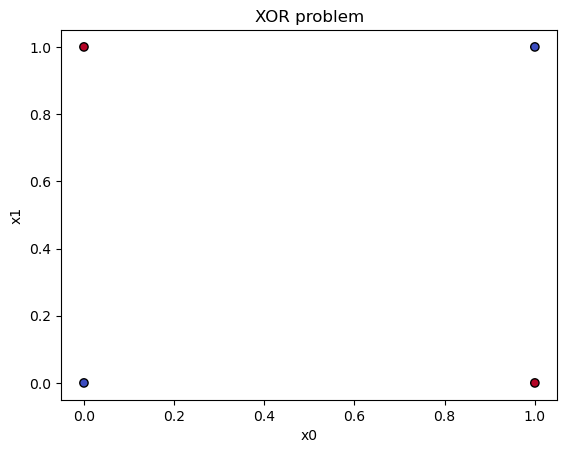

In [51]:
def plot(x, y, net=None):
    """
    Plotter function for XOR dataset and classifier boundaries (optional).

    Args:
        x: Nx2 dimensional data
        y: N dimensional labels
        net: Model which has a forward function
    """
    # Convert one-hot to class id
    y = torch.argmax(y, dim=1)

    # Plot decision boundary if net is given
    if net:
        h = 0.005
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

        xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h),
                                torch.arange(y_min, y_max, h))

        in_tensor = torch.cat((xx.reshape((-1,1)), yy.reshape((-1,1))), dim=1)

        z = net.forward(in_tensor)
        z = torch.argmax(z, dim=1)
        z = z.reshape(xx.shape)
        plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm)

    # Plot data points
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title('XOR problem')
    plt.xlabel('x0')
    plt.ylabel('x1')

    plt.show()

# Visualize
plot(x_xor, y_xor)

## A2.5 Revisiting the training loop

We will now revisit the training loop and implement the backward pass and optimizer step to train the network from the training data. We therefore need to implement the gradient of the MSE loss with respect to the prediction $\hat{y}$.

Given prediction $\hat{y}$ and groud-truth $y$ the MSE loss is defined as:
$$\text{MSE}(\hat{y},y)= \frac{1}{n} \sum_{i=1}^n (\hat{y}-y)^2 $$

Again keep in mind that $\hat{y}$ is a class probability vector and $y$ is a one-hot encoded representation.

In [52]:
def MSELoss(y_true, y_pred):
    """
    Computes mean squared error loss.

    Args:
      y_true: Tensor containing true labels.
      y_pred: Tensor containing predictions.

    Return:
      loss: Mean squared error loss.
      grad: Gradient of loss w.r.t. y_pred.
    """
    # Calculate mean squared error between y_true and y_pred
    loss = torch.mean((y_pred - y_true) ** 2)

    ########################################################################
    #             TODO: Implement the gradient dL/dy_hat                   #
    ########################################################################
    
    grad = 2 * (y_pred - y_true)

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    return loss, grad

You will now implement the training loop, which roughly speaking consists of the following steps:
```
while not converged:
 1. feed training sample to network to predict output (forward step)
 2. compare prediction to label (compute loss)
 3. use comparison to update network parameters (backward and optimizer step)
```

tensor([[0.9024, 0.1606],
        [0.0931, 0.8587],
        [0.0960, 0.8528],
        [0.9097, 0.1413]])


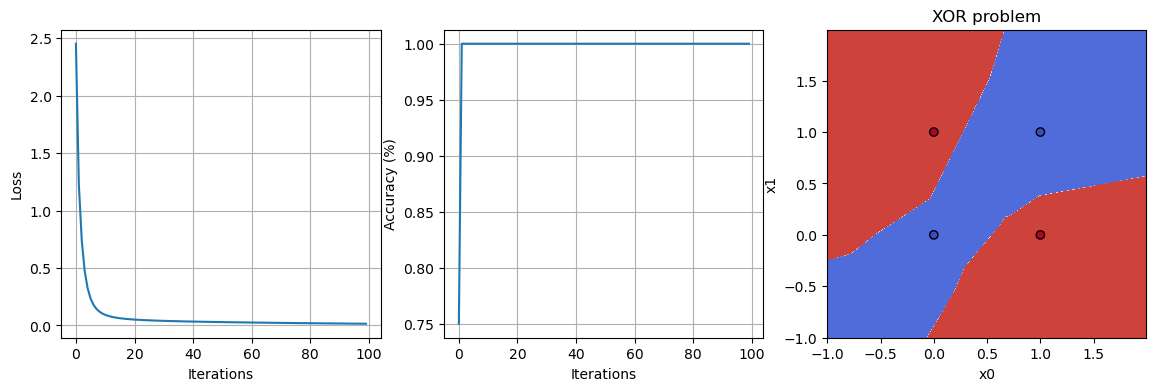

In [62]:
# Define network dimensions
in_features, hidden_dim, out_features = 2, 10, 2

# Training parameters
learning_rate = 1e-2  # step size for gradient descent
optim_steps = 100  # network should generally converge within 100 steps

# Define and initialize layers
layers = [Linear(in_features, hidden_dim),
          ReLU(),
          Linear(hidden_dim, out_features)]

# Initialize network
net = Net(layers)

# Define list to store loss and accuracy of each iteration
losses = []
accs = []

for i in range(optim_steps):
    # Perform forward pass with x_xor as input and y_pred as output variables
    y_pred = net.forward(x_xor)

    ########################################################################
    #    TODO: Calculate MSE loss between prediction and labels (y_xor)    #
    #                         and append to list.                          #
    ########################################################################

    loss, grad = MSELoss(y_xor, y_pred)
    losses.append(loss) 

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    ########################################################################
    #            TODO: Perform backward pass and optimizer step.           #
    ########################################################################

    net.backward(grad)
    net.optimizer_step(learning_rate)

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    # Calculate accuracy of prediction
    correct = torch.argmax(y_pred, axis=1) == torch.argmax(y_xor, axis=1)
    accs.append(torch.sum(correct)/len(y_pred))

# Print prediction
print(y_pred)

# Plot loss and accuracy
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.grid()

plt.subplot(1,3,2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.plot(accs)
plt.grid()

# Show decision boundary
plt.subplot(1,3,3)
plot(x_xor, y_xor, net)

The network should now successfully converge within a reasonable number of iterations and solve the XOR problem with 100% accuracy. You trained your first neural network, great job! This is still a relatively primitive optimization algorithm and we will dive more in depth into optimizing neural networks in later assignments.

Replace the ReLU non-linearity by the Sigmoid function and train the network again. You will see that the network has much more difficulty converging - in fact, you might need to increase the number of `optim_steps` to `500`. If you look at the loss graph you'll see that the network initially learns quickly, i.e. the loss rapidly decreases, but learning slows down far before reaching 100% accuracy. Since the network parameters are updated by gradient descent, slow learning simply means that the gradients have become small. To understand why this happens, let's again look at the Sigmoid function $\sigma(x)$ and its derivative $\sigma'(x)$:


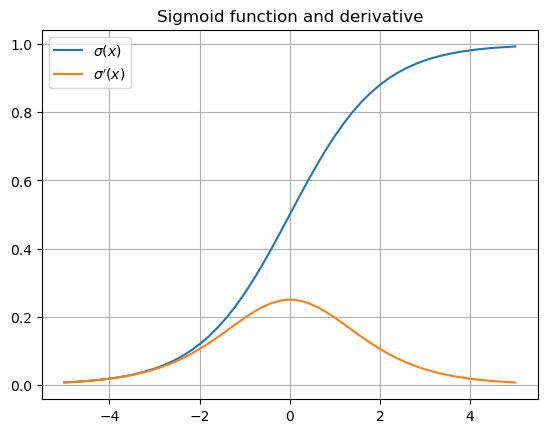

In [64]:
# Plot the sigmoid function and its derivative
x = torch.linspace(-5, 5, 51)
y = 1 / (1+torch.exp(-x))
dydx = torch.exp(x)/(1+torch.exp(x))**2

plt.title('Sigmoid function and derivative')
plt.plot(x,y)
plt.plot(x,dydx)
plt.legend([r"$\sigma(x)$", r"$\sigma'(x)$"])
plt.grid()

As you can see, the Sigmoid function saturates for very small and very large input values and as a result its derivative becomes very small, causing learning to slow down. In the next assignment we will learn how to circumvent this.

## A2.6 Softmax and Cross Entropy Loss

So far the classifier scores predicted by our network (also called 'logits') were unbounded and we simply trained the network to minimize the mean squared error between the scores and the one-hot encoded labels. However, in a classification task we would like to interpret the output of our network as class probabilities, i.e. for all inputs $x$ and all classes $k$ we should have $$0 \leq P(Y=k|X=x) \leq 1, \qquad \sum_kP(Y=k|X=x) = 1.$$
This can be achieved by normalizing the logits $z$ using the Softmax layer:
$$P(Y=k|X=x) = \text{softmax}(\mathbf{z})_k = \frac{\exp{z_k}}{\sum_i^K \exp{z_i}},$$
where $K$ is the number of classes.

Implement Softmax below and run the example. Verify that indeed the smallest and largest logits get assigned the smallest and largest probabilities and that the outputs are equal to the PyTorch implementation.

Softmax implementation correct:  True


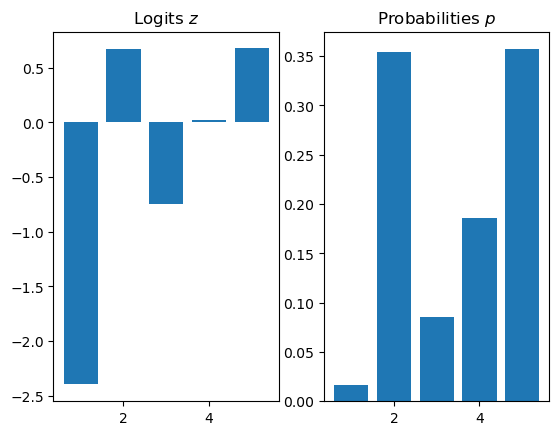

In [66]:
def Softmax(z):
    """
    Computes softmax output for each sample in batch.

    Args:
      z: Tensor of logits, dimension [batch, classes].

    Return:
      p: Softmax probability distribution.
    """

    ########################################################################
    #                  TODO: Implement Softmax function.                   #
    ########################################################################

    exps = torch.exp(z)
    p = exps / torch.sum(exps, axis = 1, keepdim=True)

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    return p

# Generate random logits, dimension [batch, classes]
z = torch.randn(1,5)
# Calculate softmax
p = Softmax(z)

# Verify against PyTorch implementation
p_torch = torch.nn.functional.softmax(z, 1)
print('Softmax implementation correct: ', torch.allclose(p, p_torch))

# Plot z and p
plt.subplot(1,2,1)
plt.title(r'Logits $z$')
_=plt.bar(torch.arange(1,6), z[0,:])
plt.subplot(1,2,2)
plt.title(r'Probabilities $p$')
_=plt.bar(torch.arange(1,6), p[0,:])

The Softmax layer is a vector extension of the Sigmoid function and so unfortunately comes with the same saturation problem causing learning to slow down. Luckily we can overcome this by replacing the MSE loss by the Cross Entropy (CE) loss:
$$H(y,p) = -\sum_i^K y_i \log(p_i),$$
where $y$ is the one-hot encoded label and $p$ is the class probability vector from the Softmax layer.
Using the CE loss with the Softmax layer is effective as the $\log$ in the CE loss can undo the $\exp$ in the Softmax layer:
$$\log \text{softmax}(\mathbf{z})_k = z_k - \log \sum_i^K \exp z_i.$$
Because now $z_k$ has a direct contribution to the loss it can never saturate and the gradients will never become too small.

The Softmax layer and Cross Entropy loss are used together so often that they are implemented as a single function in Pytorch as `torch.nn.CrossEntropyLoss`. Below we have implemented the CE loss with Softmax so we can use it to train our network. Feel free to go over the code, but you do not need to understand it exactly as the implementation is not very straightforward.

In [67]:
def CrossEntropyLoss(y_true, y_pred):
    """
    Computes softmax output and cross-entropy loss.

    Args:
      y_true: Tensor containing true labels.
      y_pred: Tensor containing predictions.

    Return:
      loss: Cross-entropy loss.
      dy_pred: Gradient of loss w.r.t. y_pred.
    """

    # Calculate softmax using previously defined function
    softmax = Softmax(y_pred)

    # Convert one-hot vector to class id
    y_true = torch.argmax(y_true, axis=1)
    # Get number of samples in batch
    n = y_true.shape[0]
    # Calculate cross entropy loss between y_true and y_pred
    log_likelihood = -torch.log(softmax[torch.arange(n),y_true])
    # Average over all samples
    loss = torch.mean(log_likelihood)

    # Caculate the gradient
    grad = softmax
    softmax[torch.arange(n), y_true] -= 1
    grad /= n

    return loss, grad

We will now solve the XOR problem by training the network with the Cross Entropy loss and Sigmoid activation function. The network should be able to converge much faster than using the MSE loss.

In [ ]:
# Define network dimensions
in_features, hidden_dim, out_features = 2, 10, 2

# Training parameters
learning_rate = 5e-1  # step size for gradient descent
optim_steps = 150  # network should generally converge within 100 steps

# Define and initialize layers
layers = [Linear(in_features, hidden_dim),
          Sigmoid(),
          Linear(hidden_dim, out_features)]

# Initialize network
net = Net(layers)

# Define list to store loss and accuracy of each iteration
losses = []
accs = []

for i in range(optim_steps):
    # Perform forward pass with x_xor as input and y_pred as output variables
    y_pred = net.forward(x_xor)

    ########################################################################
    #      TODO: Calculate Cross Entropy loss between prediction and       #
    #                  labels (y_xor) and append to list.                  #
    ########################################################################

    loss, grad = CrossEntropyLoss(y_pred,y_xor)
    losses.append(loss)
    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    ########################################################################
    #            TODO: Perform backward pass and optimizer step.           #
    ########################################################################

    for layer in layers: 
        layer.backward(grad)
        

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    # Calculate accuracy of prediction
    correct = torch.argmax(y_pred, axis=1) == torch.argmax(y_xor, axis=1)
    accs.append(torch.sum(correct)/len(y_pred))

# Print prediction
print(y_pred)

# Plot loss and accuracy
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.grid()

plt.subplot(1,3,2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.plot(accs)
plt.grid()

# Show decision boundary
plt.subplot(1,3,3)
plot(x_xor, y_xor, net)

## [EXTRA] A2.7 MNIST handwritten digit classification
In this extra exercise you will use your neural network to solve a real-world classification problem: classifying handwritten digits.

The MNIST dataset consists of a training set of 60,000 and a test set of 10,000 samples of 28x28 pixels, which we will flatten to a 1D vector representation to feed into the neural network. In every training iteration we will sample a random batch of 64 data samples (without replacement) to calculate the loss, gradients and update the weights. This random sampling is where the 'Stochastic' in Stochastic Gradient Descent comes from. After every epoch, i.e. after having processed all sampels in the training set, we will evaluate the model on the test set.

The following code block downloads the dataset and visualizes some samples.



In [ ]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Get data from torchvision.datasets
train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

# Show some example images
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = test_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
########################################################################
#             TODO: Define appropriate network dimensions.             #
########################################################################

pass

########################################################################
#                          END OF YOUR CODE                            #
########################################################################

# Training parameters
learning_rate = 5e-1  # step size for gradient descent
epochs = 10  # how many times to iterate through the intire training set

# Define and initialize layers
layers = [Linear(in_features, hidden_dim),
          Sigmoid(),
          Linear(hidden_dim, out_features)]

# Initialize network
net = Net(layers)

# Define list to store loss of each iteration
train_losses = []
train_accs = []

for epoch in range(epochs):
    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Flatten input to 1D tensor
        x_batch = x_batch.flatten(start_dim=1)
        # Convert labels to one-hot encoding
        y_batch = nn.functional.one_hot(y_batch, num_classes=10)

        # Perform forward pass
        y_pred = net.forward(x_batch)

        ########################################################################
        #      TODO: Calculate Cross Entropy loss between prediction and       #
        #                     labels and append to list.                       #
        ########################################################################

        pass

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################


        ########################################################################
        #            TODO: Perform backward pass and optimizer step.           #
        ########################################################################

        pass

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        # Calculate accuracy of prediction
        correct = torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)
        train_accs.append(torch.sum(correct)/len(y_pred))

        # Print progress
        if i % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, i * len(x_batch), len(train_loader.dataset),
                100. * i / len(train_loader), loss))

    # Validation loop
    test_loss = 0
    total_correct = 0
    for x_batch, y_batch in test_loader:
        # Flatten input to 1D tensor
        x_batch = x_batch.flatten(start_dim=1)
        # Convert labels to one-hot encoding
        y_batch = nn.functional.one_hot(y_batch, num_classes=10)

        # Perform forward pass with x_xor as input and y_pred as output variables
        y_pred = net.forward(x_batch)

        ########################################################################
        #   TODO: Calculate Cross Entropy loss between prediction and labels.  #
        ########################################################################

        pass

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        # Keep track of total loss over test set
        test_loss += loss

        # Calculate accuracy of prediction
        correct = torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)
        total_correct += torch.sum(correct)

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * total_correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, total_correct, len(test_loader.dataset), test_acc))

# Plot training curves
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs)
plt.grid()

Your network can now classify handwritten digits with reasonably high accuracy. Well done!

This concludes the second assignment. From the next assignment onwards we will start using more and more built-in PyTorch functionality and will get to know some more advanced methods for training neural networks. Also, we will implement the most prominent building block of modern computer vision: the convolutional layer.